# Segmentation Best Practices

In this notebook, we will walk through how to use H2O-3 to find natural segments in a dataset. We will walk through two methods for clustering:

- using k-means to find natural segments in the data
- using GLRM to create column and row archetypes
- using GLRM to remove correlated columns and using k-means to cluster that data (this removes the effect of correlated variables in clustering)

## Import and Explore Data

We begin by importing our wholesale customer data.  This annual spending on different types of grocery products. The dataset description can be found here: https://archive.ics.uci.edu/ml/datasets/wholesale+customers

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [3]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o


Checking whether there is an H2O instance running at http://localhost:32479..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa0ph7jeg
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa0ph7jeg/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa0ph7jeg/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:32479
Connecting to H2O server at http://127.0.0.1:32479... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,"14 days, 4 hours and 18 minutes"
H2O cluster name:,H2O_from_python_bear_e4cztd
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [4]:
hf_customers = h2o.import_file("data/WholesaleCustomersData.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
hf_customers.describe()

Rows:440
Cols:8




,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
type,int,int,int,int,int,int,int,int
mins,1.0,1.0,3.0,55.0,3.0,25.0,3.0,3.0
mean,1.3227272727272712,2.543181818181819,12000.297727272731,5796.265909090916,7951.277272727275,3071.931818181817,2881.49318181818,1524.8704545454532
maxs,2.0,3.0,112151.0,73498.0,92780.0,60869.0,40827.0,47943.0
sigma,0.4680515694791137,0.7742724492301002,12647.328865076885,7380.377174570845,9503.162828994346,4854.673332592367,4767.854447904201,2820.1059373693965
zeros,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0
0,2.0,3.0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,2.0,3.0,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,2.0,3.0,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0


The columns `Channel` and `Region` are encoded with ID's.  We will replace this with readable values.

In [6]:
# Replace Channel with values
hf_customers["Channel"] = (hf_customers["Channel"] == 1).ifelse("Hotel/Restaurant", "Retail")

In [7]:
# Replace Region with values
hf_customers["Region"] = (hf_customers["Region"] == 1).ifelse("Lisbon", 
                                                              (hf_customers["Region"] == 2).ifelse("Oporto", "Other"))

In [8]:
hf_customers.head()

Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Retail,Other,12669,9656,7561,214,2674,1338
Retail,Other,7057,9810,9568,1762,3293,1776
Retail,Other,6353,8808,7684,2405,3516,7844
Hotel/Restaurant,Other,13265,1196,4221,6404,507,1788
Retail,Other,22615,5410,7198,3915,1777,5185
Retail,Other,9413,8259,5126,666,1795,1451
Retail,Other,12126,3199,6975,480,3140,545
Retail,Other,7579,4956,9426,1669,3321,2566
Hotel/Restaurant,Other,5963,3648,6192,425,1716,750
Retail,Other,6006,11093,18881,1159,7425,2098


We can calculate the correlation of the data to get a better understanding of our customers.

In [9]:
correlations = hf_customers.cor()
correlations = h2o.H2OFrame(hf_customers.col_names).cbind(correlations)

correlations

Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1,nan,0.169172,-0.46072,-0.608792,0.202046,-0.636026,-0.0560114
Region,nan,nan,nan,nan,nan,nan,nan,nan
Fresh,0.169172,nan,1,0.10051,-0.0118539,0.345881,-0.101953,0.24469
Milk,-0.46072,nan,0.10051,1,0.728335,0.123994,0.661816,0.406368
Grocery,-0.608792,nan,-0.0118539,0.728335,1,-0.0401927,0.924641,0.205497
Frozen,0.202046,nan,0.345881,0.123994,-0.0401927,1,-0.131525,0.390947
Detergents_Paper,-0.636026,nan,-0.101953,0.661816,0.924641,-0.131525,1,0.0692913
Delicassen,-0.0560114,nan,0.24469,0.406368,0.205497,0.390947,0.0692913,1


In [10]:
hf_customers.group_by("Channel").mean("Grocery").get_frame()

Channel,mean_Grocery
Retail,16322.9
Hotel/Restaurant,3962.14


The correlation matrix shows us that `Grocery`, `Milk`, and `Detergents_Paper` are all highly correlated.  We also see that there is a smaller correlation with purchasing `Fresh`, `Frozen`, and `Delicassen`.

There is a 60% correlation between `Channel` and `Grocery` and a 63% correlation between `Channel` and `Detergents_Paper`.  The group-by below shows us that `Grocery` and `Detergents_Paper` are primarily purchased in the Retail channel and not in the Hotel/Restaurant channel.

In [11]:
hf_customers.group_by("Channel").mean("Grocery").mean("Detergents_Paper").get_frame()

Channel,mean_Grocery,mean_Detergents_Paper
Retail,16322.9,7269.51
Hotel/Restaurant,3962.14,790.56


## Clustering with K-Means

We will use K-Means to cluster the data.  We will let the K-Means model estimate the optimal number of clusters.

In [12]:
from h2o.estimators.kmeans import H2OKMeansEstimator

kmeans_default = H2OKMeansEstimator(estimate_k = True, # Let Kmeans chose the optimal number of clusters
                                    k = 20, # Max number of clusters
                                    model_id = "kmeans_default.hex")

kmeans_default.train(training_frame = hf_customers)

kmeans Model Build progress: |████████████████████████████████████████████| 100%


We have 8 clusters.  Most of the customers fall into the first 4 clusters.

In [13]:
# View the centroids
kmeans_default.centroid_stats()

Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,220.0,237.2697849
,2.0,109.0,179.8460864
,3.0,29.0,172.7302138
,4.0,71.0,222.1209477
,5.0,1.0,0.0000000
,6.0,4.0,27.9634194
,7.0,4.0,50.4986385
,8.0,2.0,19.6456850


In [14]:
# Add the cluster to the original frame
cluster_id = kmeans_default.predict(hf_customers)
cluster_id.col_names = ["cluster_default"]
hf_customers_ext = hf_customers.cbind(cluster_id)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [15]:
hf_customers_ext.head()

Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster_default
Retail,Other,12669,9656,7561,214,2674,1338,1
Retail,Other,7057,9810,9568,1762,3293,1776,1
Retail,Other,6353,8808,7684,2405,3516,7844,1
Hotel/Restaurant,Other,13265,1196,4221,6404,507,1788,0
Retail,Other,22615,5410,7198,3915,1777,5185,3
Retail,Other,9413,8259,5126,666,1795,1451,1
Retail,Other,12126,3199,6975,480,3140,545,1
Retail,Other,7579,4956,9426,1669,3321,2566,1
Hotel/Restaurant,Other,5963,3648,6192,425,1716,750,0
Retail,Other,6006,11093,18881,1159,7425,2098,1


### Understanding the Clusters

In order to understand the clusters, we can plot them by the different variables in our dataset.

In [16]:
# Convert H2O Frame to Pandas to use matplotlib
customers_pd = hf_customers_ext.as_data_frame()

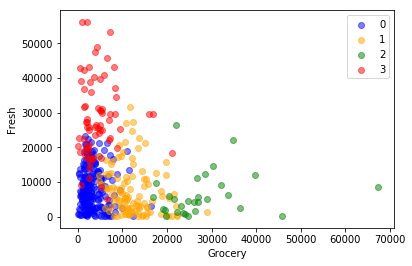

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red']

for cluster, color in enumerate(colors):
    cluster_data = customers_pd[customers_pd["cluster_default"] == cluster]
    plt.scatter(cluster_data["Grocery"], cluster_data["Fresh"], c=color, alpha = 0.5, label = cluster)

plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.legend()

From the graph, we can clearly identify the clusters from just two features: Grocery and Fresh.  

| Cluster | Amount of Groceries | Amount of Fresh Products |
|---------|---------------------|--------------------------|
| 0 | Small | Small |
| 1 | Medium | Small |
| 2 | Large | Small |
| 3 | Small | Large | 


Why is this happening even though we clustered on 8 columns? 

The reason is because `Grocery` is highly correlated with the other features like `Detergents_Paper`, `Milk`, and `Channel`.  If the amount of groceries someone buys is directly related to the amount of paper products and milk they purchase and the channel they purchase in, then it is almost like the `Grocery` feature has a weight of 4 in the clustering algorithm.  Now the amount of groceries a customer purchases is very important in the clusters.

The box plot below shows the distribution of `Grocery` for each cluster.  The clusters are almost completely explainable by the one column.

/Users/bear/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


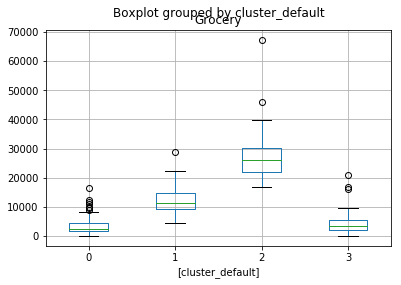

In [18]:
customers_pd.loc[customers_pd["cluster_default"] < 4, ["Grocery", "cluster_default"]].boxplot(by='cluster_default')

## Generalized Low Rank Modeling

We can use low dimensionality techniques like Generalized Low Rank models to condense the features of the dataset and remove the correlations.  Below we will train a GLRM model on our customer data and reduce the number of dimensions to 2 so we can visualize the archetypes of the data in 2-dimensional graphs.

In [19]:
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# Run GLRM to reduce features to 2 attributes
glrm_2_model = H2OGeneralizedLowRankEstimator(k = 2,
                                             transform = "STANDARDIZE",
                                             loss = "Quadratic",
                                             regularization_x = "L1",
                                             regularization_y = "L1",
                                             gamma_x = 0.1,
                                             gamma_y = 0.1,
                                             seed = 1234,
                                             model_id = "glrm_2")
glrm_2_model.train(x = hf_customers.names, training_frame= hf_customers)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


### Interpreting Archetypes

We will start by interpreting the feature archetypes.  Each feature is represented by a vector of length 2.

In [20]:
arch_feat_y = glrm_2_model._model_json["output"]["archetypes"]
print(arch_feat_y)

Archetypes: 


,regionlisbon,regionoporto,regionother,channelretail,channelhotelrestaurant,fresh,milk,grocery,frozen,detergents_paper,delicassen
Arch1,-0.7161905,-1.8101773,0.7198309,-3.4178960,3.4178828,0.1267454,-1.5396457,-1.7872226,0.1510788,-1.7840776,-0.4684157
Arch2,-1.3290650,-1.2798304,1.3224241,3.0791896,-3.0792011,0.0100947,1.7342810,1.9142572,-0.0561190,1.8675144,0.6595436


In [24]:
print(arch_feat_y)

Archetypes: 


,regionlisbon,regionoporto,regionother,channelretail,channelhotelrestaurant,fresh,milk,grocery,frozen,detergents_paper,delicassen
Arch1,-0.7161905,-1.8101773,0.7198309,-3.4178960,3.4178828,0.1267454,-1.5396457,-1.7872226,0.1510788,-1.7840776,-0.4684157
Arch2,-1.3290650,-1.2798304,1.3224241,3.0791896,-3.0792011,0.0100947,1.7342810,1.9142572,-0.0561190,1.8675144,0.6595436


The scatter plot below shows the two archetypes.  We can see that `grocery` and `detergents_paper` are very close together.  We can also see that the two channels are very far apart.  Depending on the channel, the customer will have a very different buying pattern.

We can use the GLRM model to get a 2 dimensional representation of the original data.

In [25]:
# Get Low Dimensional Data
glrm_arch_x = h2o.get_frame(glrm_2_model._model_json["output"]["representation_name"])
glrm_arch_x.head()

Arch1,Arch2
0.285449,0.600976
0.260797,0.614248
0.261014,0.614426
0.686513,0.382634
0.334414,0.579385
0.353712,0.563744
0.380212,0.549291
0.297055,0.594615
0.678479,0.428223
0.184505,0.670446


Plotting the first two archetypes of the customers shows that there are two natural segments occurring.

Text(0,0.5,'Arch2')

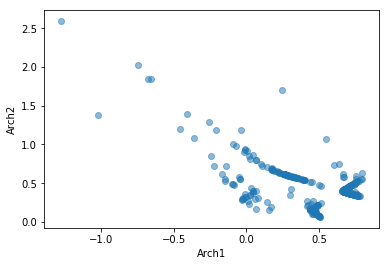

In [26]:
arch_pd = hf_customers.cbind(glrm_arch_x).as_data_frame()
plt.scatter(arch_pd["Arch1"], arch_pd["Arch2"], alpha = 0.5)

plt.xlabel("Arch1")
plt.ylabel("Arch2")

## Clustering with GLRM Data

We can also use GLRM to remove correlated variables from the data.  This would prevent our k-means model from being overly weighted by correlated variables such as Grocery.

If we run GLRM with no dimensionality reduction, we can see that the first 4 archetypes account for more than 90% of variance.  Therefore, we will reduce the size of our data to 4 archetypes.

In [27]:
# Run GLRM without reduction
glrm_model = H2OGeneralizedLowRankEstimator(k = 8,
                                            transform = "STANDARDIZE",
                                            loss = "Quadratic",
                                            regularization_x = "L1",
                                            regularization_y = "L1",
                                            gamma_x = 0.1,
                                            gamma_y = 0.1,
                                            seed = 1234,
                                            model_id = "glrm_4")
glrm_model.train(x = hf_customers.names, training_frame= hf_customers)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [28]:
glrm_model._model_json["output"]["importance"]

Importance of components: 


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
Standard deviation,1.7224688,1.6983412,0.8586318,0.8032225,0.5225184,0.4785542,0.4257691,0.2959058
Proportion of Variance,0.3706513,0.3603402,0.0921036,0.0805999,0.0341088,0.0286105,0.0226470,0.0109388
Cumulative Proportion,0.3706513,0.7309914,0.8230950,0.9036949,0.9378037,0.9664142,0.9890612,1.0000000


In [29]:
# Run GLRM to reduce features to 4 attributes

glrm_4_model = H2OGeneralizedLowRankEstimator(k = 4,
                                              transform = "STANDARDIZE",
                                              loss = "Quadratic",
                                              regularization_x = "L1",
                                              regularization_y = "L1",
                                              gamma_x = 0.1,
                                              gamma_y = 0.1,
                                              seed = 1234,
                                              model_id = "glrm_4")
glrm_4_model.train(x = hf_customers.names, training_frame= hf_customers)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [30]:
# Get low dimensionality data

glrm_arch_x = h2o.get_frame(glrm_4_model._model_json["output"]["representation_name"])

glrm_arch_x.head()

Arch1,Arch2,Arch3,Arch4
0.0495125,0.262456,-0.0344763,-0.0288137
0.0697408,0.269944,-0.0147671,-0.0590434
0.125507,0.3013,0.10354,-0.133852
0.60467,0.150048,-0.0867186,0.127563
0.0490751,0.300332,0.0205804,0.0468216
0.0564371,0.263664,-0.0365405,-0.0420525
0.0427085,0.266842,-0.0745636,-0.00779223
0.0677786,0.269088,-0.0170879,-0.0561693
0.460301,0.216133,-0.0929497,-0.0142577
-0.0712903,0.561966,-0.0148183,-0.109197


Now we can train k-means on our 4 column dataset.  The k-means model only finds 2 clusters.

In [31]:
kmeans_glrm = H2OKMeansEstimator(estimate_k = True, # Let Kmeans chose the optimal number of clusters
                                 k = 20, # Max number of clusters
                                 model_id = "kmeans_glrm.hex")

kmeans_glrm.train(training_frame = glrm_arch_x)

kmeans_glrm.centroid_stats()

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,229.0,332.4632398
,2.0,211.0,890.3120529


In [32]:
# Add the cluster to the original frame
cluster_glrm_id = kmeans_glrm.predict(glrm_arch_x) + 1
cluster_glrm_id.col_names = ["cluster_glrm"]

hf_customers_ext = hf_customers_ext.cbind(glrm_arch_x)
hf_customers_ext = hf_customers_ext.cbind(cluster_glrm_id)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


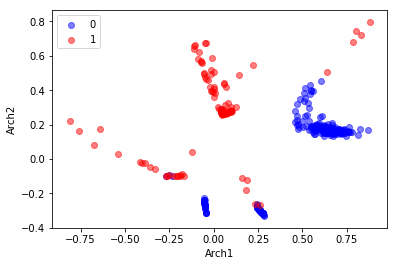

In [33]:
# Convert H2O Frame to Pandas 
customers_pd = hf_customers_ext.as_data_frame()

colors = ['blue', 'red']

for cluster, color in enumerate(colors):
    cluster_data = customers_pd[customers_pd["cluster_default"] == cluster]
    plt.scatter(cluster_data["Arch1"], cluster_data["Arch2"], c=color, alpha = 0.5, label = cluster)

plt.xlabel("Arch1")
plt.ylabel("Arch2")
plt.legend()

We will again plot the clusters on the original features to better understand them.

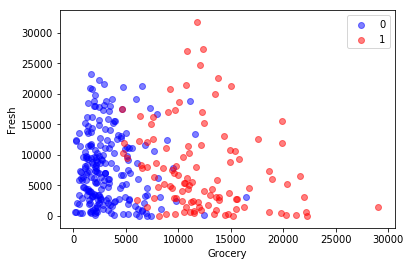

In [34]:
for cluster, color in enumerate(colors):
    cluster_data = customers_pd[customers_pd["cluster_default"] == cluster]
    plt.scatter(cluster_data["Grocery"], cluster_data["Fresh"], c=color, alpha = 0.5, label = cluster)

plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.legend()

Now the clusters are not easily explainable across just two dimensions.  Grocery and it's correlated features are no longer over weighted in the kmeans cluster because we have removed all correlations.  If we take a look at the cluster distribution by `Channel`, we can see that Retail customers are primarily in cluster 2.  Hotel/Restaurant customers are primarily in cluster 1.

In [35]:
print("Retail Channel")
print(hf_customers_ext[hf_customers_ext["Channel"] == "Retail", "cluster_glrm"].table())

print("Hotel/Restaurant")
hf_customers_ext[hf_customers_ext["Channel"] == "Hotel/Restaurant", "cluster_glrm"].table()

Retail Channel


cluster_glrm,Count
1,5
2,137



Hotel/Restaurant


cluster_glrm,Count
1,224
2,74


We can also understand the clusters more by calculating the average of the annual purchasing per cluster:

In [36]:
hf_customers_ext.group_by("cluster_glrm").mean("Fresh").mean("Milk").mean("Grocery").mean("Frozen").mean("Detergents_Paper").mean("Delicassen").get_frame()

cluster_glrm,mean_Fresh,mean_Milk,mean_Grocery,mean_Frozen,mean_Detergents_Paper,mean_Delicassen
1,15080.3,3237.85,3777.99,3548.87,783.891,1230.52
2,8657.54,8572.93,12480.6,2554.31,5158.04,1844.33


 I would explain these clusters as: 

* Cluster 1: Restaurants/Hotels who buy a lot of Frozen and Fresh produce
* Cluster 2: Retail customers who buy a lot of groceries and Detergents/Paper

In [37]:
h2o.cluster().shutdown()

H2O session _sid_a9ca closed.
